In [24]:
#For importing data.
import sys
import os
sys.path.append("..")  # Adds higher directory to python modules path.
import pandas as pd
import numpy as np
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

#PCA
import sklearn.datasets as ds
from sklearn import decomposition

#For analyzing similarity
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

In [2]:
pic_embs = pickle.load(open('./Nat_Gard_Build/models/data.pkl', 'rb'))
plant_dat = pd.read_csv('./Nat_Gard_Build/models/USDA_Lady_Plants.csv', index_col = 0)

In [3]:
#Retrieve Model
model = models.resnet18(pretrained=True)
layer = model._modules.get('avgpool')
model.eval()

#Transforms
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

In [4]:
def get_vector(image_name):
    # 1. Load the image with Pillow library
    img = Image.open(image_name)
    #print(plt.imshow(img))
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    # 3. Create a vector of zeros that will hold our feature vector
    #    The dd'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.squeeze())
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    test=model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature bvector
    return my_embedding

In [5]:
new_img = get_vector('./Nat_Gard_Build/static/tmp/T1_flower.jpg')
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

In [6]:
select = 'CO'
IDs = plant_dat.USDA_ID.unique()

File = []
for i in range(len(IDs)):
    File.append(IDs[i]+'.jpg')
    
all_embs = {}
for i in File:
    if(i in pic_embs.keys()):
        all_embs[i] = pic_embs[i]

In [7]:
pic_cos = {}
for plant in all_embs:
    pic_cos[plant] = cos(new_img.unsqueeze(0),all_embs[plant].unsqueeze(0)).item()

df = pd.DataFrame(columns=['File','Similarity'])
df['File'] = list(pic_cos.keys())
df['Similarity'] = list(pic_cos.values())

USDA_ID = {}
for i in df.index:
    USDA_ID[i] = df['File'][i].split('.')[0]
df['USDA_ID'] = pd.Series(USDA_ID)

sim_df = pd.merge(plant_dat,df)

Plot the similarity of the image by known USDA plant type categorization.

/Users/kylechezik/Documents/Research_Apps/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


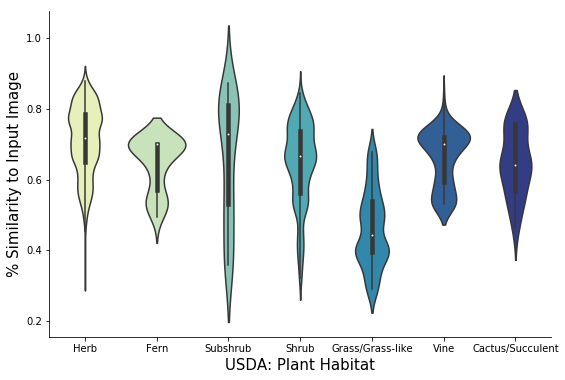

In [8]:
plt.subplots(figsize=(9,6))
#g = sns.swarmplot(x="Plant_Type", y="Similarity", hue = "Plant_Type",
g = sns.violinplot(x="Plant_Type", y="Similarity",
                palette="YlGnBu", data=sim_df,
                  order=['Herb','Fern','Subshrub','Shrub','Grass/Grass-like','Vine','Cactus/Succulent'])
g.set_xlabel("USDA: Plant Habitat",fontsize=15)
g.set_ylabel("% Similarity to Input Image",fontsize=15)
#g.legend_.remove()
sns.despine()
plt.savefig("./Nat_Gard_Build/static/tmp/plot1.jpg", format="jpg", dpi = 200)

In [8]:
sim_df = sim_df[sim_df['State']==select].sort_values('Similarity',ascending=False)

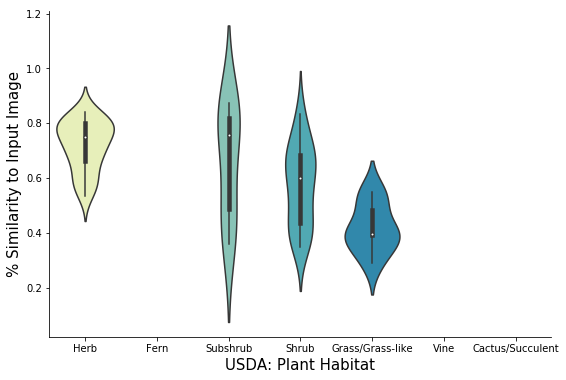

In [25]:
plt.subplots(figsize=(9,6))
#g = sns.swarmplot(x="Plant_Type", y="Similarity", hue = "Plant_Type",
g = sns.violinplot(x="Plant_Type", y="Similarity",
                palette="YlGnBu", data=sim_df,
                  order=['Herb','Fern','Subshrub','Shrub','Grass/Grass-like','Vine','Cactus/Succulent'])
g.set_xlabel("USDA: Plant Habitat",fontsize=15)
g.set_ylabel("% Similarity to Input Image",fontsize=15)
#g.legend_.remove()
sns.despine()
plt.savefig("./Nat_Gard_Build/static/tmp/plot2.jpg", format='jpg', dpi = 200)

Compare feature values for most similar and least similar.

In [10]:
print(sim_df.head(),'\n',sim_df.tail())

            Scientific_Name             Common_Name   Duration Plant_Type  \
2686     Campanula uniflora       Arctic Bellflower  Perennial   Subshrub   
2367       Liatris punctata     Dotted Blazing Star  Perennial       Herb   
54    Amelanchier alnifolia  Saskatoon Serviceberry  Perennial      Shrub   
2212         Dalea purpurea   Purple Prairie Clover  Perennial   Subshrub   
1079   Gaillardia pulchella          Indian Blanket     Annual       Herb   

     Sun_Req Water_Req State USDA_ID        File  Similarity  
2686     NaN       NaN    CO   CAUN2   CAUN2.jpg    0.873916  
2367     Sun       Dry    CO    LIFA    LIFA.jpg    0.841059  
54       Sun     Moist    CO   AMAL2   AMAL2.jpg    0.832448  
2212     Sun       Dry    CO   DAPU5   DAPU5.jpg    0.828648  
1079     Sun       Dry    CO  GAGR11  GAGR11.jpg    0.822601   
              Scientific_Name                  Common_Name   Duration  \
2607          Artemisia cana             Silver Sagebrush  Perennial   
1622       Ar

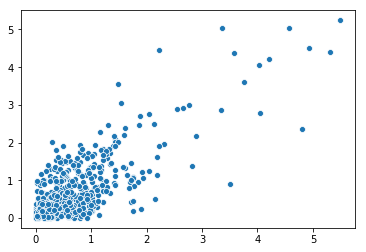

In [30]:
sns.scatterplot(x=new_img, y=pic_embs['CAUN2.jpg'])
#sns.scatterplot(x=new_img, y=pic_embs['BOCU.jpg'])

Make a ndarray and conduct a PCA analysis to determine which embedding features account for the greatest amount of variation.

In [18]:
fin = []
for j in pic_embs.keys():
    d = pic_embs[j]
    emb = []
    for i in range(d.shape[0]):
        emb.append(d[i].item())
    fin.append(emb)

fin = np.array(fin)

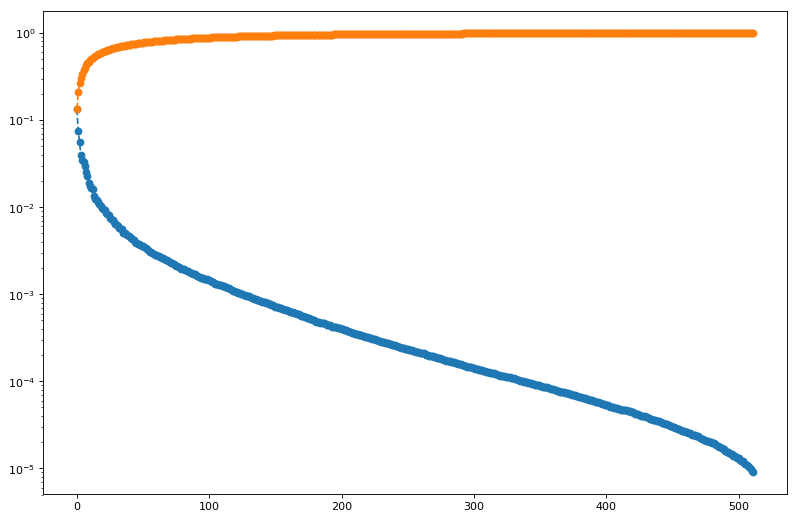

In [25]:
# Create a pca object with the 2 components as a parameter
pca = decomposition.PCA()

# Fit the PCA and transform the data
fin_pca = pca.fit(fin)

#Plot PCA
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.semilogy(fin_pca.explained_variance_ratio_, '--o');
plt.semilogy(fin_pca.explained_variance_ratio_.cumsum(), '--o');

In [26]:
sum(fin_pca.explained_variance_ratio_.cumsum()<.95)

172